

| **Chapter**                   | 2:  Host factors                                      |
| ----------------------------- | ----------------------------------------------------- |
| **Computational Note**        | 3.x: An age-differential SIR model                    |
| **Package prerequisites**     | `scipy.integrate`                                     |



# An age-differential SIR model

In this notebook, we are modeling an age-differential (or 'age-structured') model, with two groups – Upper Sixth ($U$) and Lower Sixth ($L$) –, with preferential homogenous mixing (homophily).
The model can be articulated as follows:

\begin{equation}
        \frac{dS_L}{dt} = - S_L(\beta_{L,L} I_L + \beta_{L,U} I_U) - \nu_L S_L + \mu (S_L + I_L + R_L) \\
\end{equation}

\begin{equation}
        \frac{dS_U}{dt} = - S_U(\beta_{U,U} I_U + \beta_{U,L} I_L) + \nu_L S_L \\
\end{equation}

\begin{equation}
        \frac{dI_L}{dt} = S_L (\beta_{L,L} I_L + \beta_{L,U} I_U) - \nu_L I_L - \gamma I_L \\
\end{equation}

\begin{equation}
        \frac{dI_U}{dt} = S_U (\beta_{U,U} I_U + \beta_{U,L} I_L) + \nu_L I_L - \gamma I_U
\end{equation}

\begin{equation}
        \frac{dR}{dt} = \gamma I_L + \gamma I_U - \theta R_L
\end{equation}

The WAIFW matrix is a symmetric matrix that articulates the homophily of each cohort:

\begin{equation}
    b = \begin{pmatrix}
        8 & 4\\
        4 & 8
    \end{pmatrix}    
\end{equation}

We use the methods previously enumerated for solving the associated IVP.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

## Set initial value parameters

We set the initial value parameters:

* Initial infectious population ($I_0$): 0.01
* $S_0$: $0.5 - I_0$ per cohort
* $\mu$ (mortality rate): 0.01
* $\nu$ (transition rate): 0.02
* $\theta$ (pass-out from the Upper Sixth, 'aging out' rate): 0.015
* $\gamma$: $\frac{1}{20}$

In [2]:
I_0 = 1e-3
S_0 = 0.5 - I_0
R_0 = 0

y_0 = (S_0, I_0, S_0, I_0, R_0, R_0)

mu = 0.01
nu = 0.02
theta = 0.015
gamma = 1/20

beta = [8, 4, 4, 8]

## Defining the system of ODEs as a function

In [3]:
def deriv(t, y, beta, gamma, mu, nu, theta):
    S_L, I_L, S_U, I_U, R_U, R_L = y
    
    dSLdt = - S_L * (beta[0] * I_L + beta[1] * I_U) - nu * S_L + mu * (S_L + I_L + R_L)
    dSUdt = - S_U * (beta[2] * I_L + beta[3] * I_U) + nu * S_L

    dILdt = S_L * (beta[0] * I_L + beta[1] * I_U) - nu * I_L - gamma * I_L
    dIUdt = S_U * (beta[2] * I_L + beta[3] * I_U) + nu * I_L - gamma * I_U

    dRLdt = gamma * I_L - nu * R_L
    dRUdt = gamma * I_U + nu * R_L - theta * R_U

    return dSLdt, dILdt, dSUdt, dIUdt, dRUdt, dRLdt

## Solve the IVP

In [4]:
res = solve_ivp(fun=deriv, t_span = (0, 400), y0=y_0, args=(beta, gamma, mu, nu, theta), max_step=1, method="BDF")

## Plot results

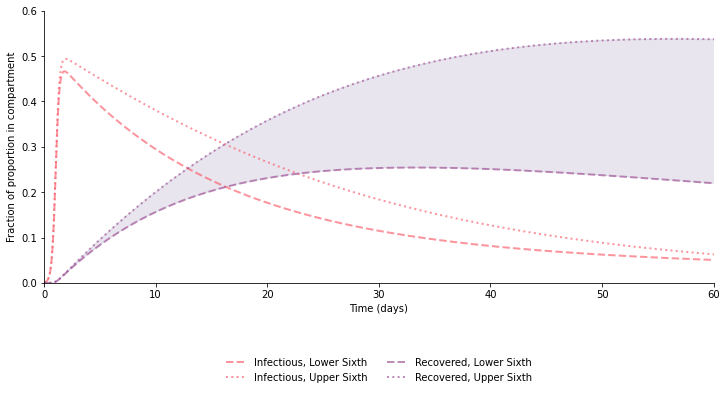

In [5]:
SL, IL, SU, IU, RU, RL = res.y

fig = plt.figure(facecolor="w", figsize=(12,6))
ax = fig.add_subplot(111, axisbelow=True)

ax.plot(res.t, IL, color=COLORS["I"], alpha=0.66, lw=2, label="Infectious, Lower Sixth", linestyle="dashed")
ax.plot(res.t, IU, color=COLORS["I"], alpha=0.66, lw=2, label="Infectious, Upper Sixth", linestyle="dotted")

ax.plot(res.t, RL, color=COLORS["R"], alpha=0.66, lw=2, label="Recovered, Lower Sixth", linestyle="dashed")
ax.plot(res.t, RU, color=COLORS["R"], alpha=0.66, lw=2, label="Recovered, Upper Sixth", linestyle="dotted")

ax.fill_between(res.t, RL, RU, color=COLORS["X"], alpha=0.15)

ax.set_xlabel('Time (days)')
ax.set_ylabel("Fraction of proportion in compartment")
ax.set_xlim(0, 60)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.legend(title='', bbox_to_anchor=(0.5, -0.4), loc="lower center", ncol=2, frameon=False)

fig.subplots_adjust(bottom=0.25)

ax.set_ylim(0, .6)

plt.savefig("by_age_group.pdf", dpi=1200)
plt.show()